# Multiple Results Analysis

This notebook is intended to read a simulation results file with multiple simulations and results and create aggregate analyses and visualizations.

**Goal**:

1. Raft doesn't commit forks 
2. Raft accepts first seen 
3. Eventual chooses raft then latest

**Experimental control variables:**

- _increasing WAN latency, e.g. T (tick)_
- increasing number of nodes
- increasing amounts of failure

**Metrics:**

- number of forks
- number of stale reads
- percent visible (for full replication)
- percent committed
- number of messages
- read latency
- write latency
- visibility latency
- commit latency

In [1]:
%matplotlib inline

import os
import sys 
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import graph_tool.all as gt
import matplotlib.pyplot as plt

from operator import itemgetter
from itertools import groupby, chain
from collections import defaultdict, Counter

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.colors import ColorMap
from cloudscope.results import Results
from cloudscope.results.graph import extract_graph
from cloudscope.results.analysis import create_per_replica_dataframe as create_replica_dataframe
from cloudscope.results.analysis import create_per_experiment_dataframe as create_dataframe
from cloudscope.results.analysis import results_values as rvals

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
sns.set_style('whitegrid')
sns.set_context('notebook')

In [3]:
# Specify a path to a results file 
# If None, will attempt to look one up
FIXTURES = os.path.join("..", "fixtures", "results")
# RESULTS  = os.path.join(FIXTURES, "federated-multi-original-1user-bailis.json")
RESULTS  = os.path.join(FIXTURES, "federated-multi-original-1user-howard.json")

def get_results_data(path=RESULTS):
    with open(path, 'r') as f:
        data = json.load(f)
    
    for result in data:
        yield Results(**result)

# Load the data
results = list(get_results_data())

In [4]:
# Print report details 
def report_settings(exclude=None):
    table = defaultdict(dict)
    exclude = exclude or frozenset([
        'valid_locations', 'invalid_types', 
        'default_replica', 'default_consistency', 'default_latency', 
        'max_sim_time', 'title', 'description',
        'election_timeout', 'heartbeat_interval',
    ])
    
    for idx, conf in enumerate(rvals(results, 'settings')):
        eid = "e{:0>2}".format(idx)
        table[eid]['name'] = eid
        for key, val in conf.iteritems():
            if key in exclude: continue
            table[eid][key] = val
    
    for idx, conf in enumerate(rvals(results, 'topology', 'meta')):
        eid = "e{:0>2}".format(idx)
        for key, val in conf.iteritems():
            if key in exclude: continue
            table[eid][key] = val

    return pd.DataFrame(table.values())

settings = report_settings()

In [5]:
df = create_dataframe(results)
df = df.fillna(0)

In [6]:
print("\n".join(df.columns))

T parameter model
anti-entropy delay (ms)
committed writes
completed reads
completed writes
dropped write latency
dropped writes
eid
election timeout (ms, ms)
empty reads
forked writes
heartbeat interval (ms)
latency range (ms)
mean commit latency (ms)
mean latency (ms)
mean message latency (ms)
mean read latency (ms)
mean visibility latency (ms)
mean write latency (ms)
message types
reads
recv
sent
stale reads
standard deviation of latency (ms)
tick metric (T)
type
users
visible writes
writes


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


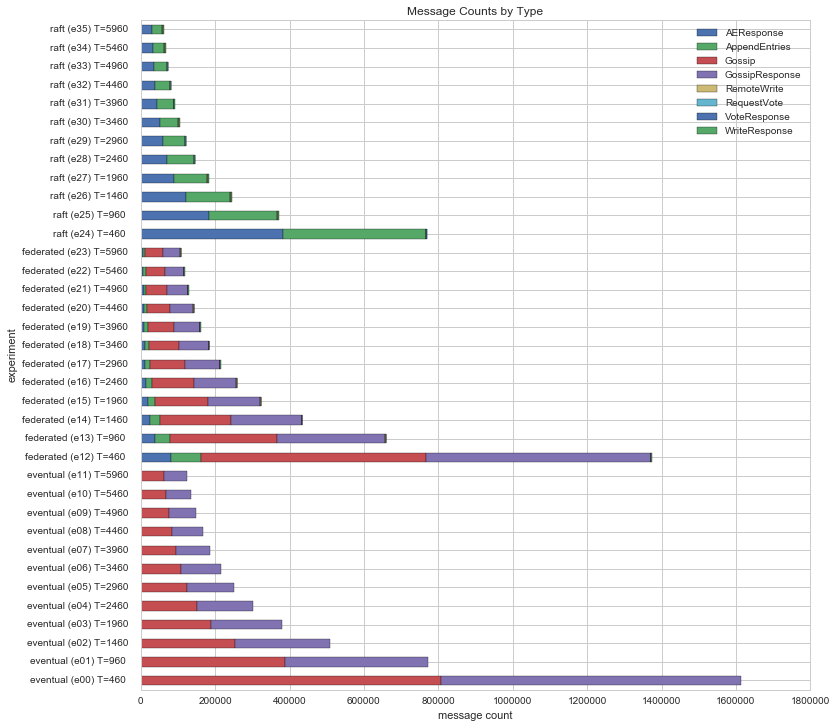

In [7]:
def get_message_rows(df):
    for row in df[['message types', 'tick metric (T)', 'type', 'eid']].itertuples(): 
        item = row[1]
        item['experiment'] = "{} ({}) T={: <6}".format(row[3], row[4], row[2])
        yield item

msgs = pd.DataFrame(get_message_rows(df))

fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(111)
mpl.rcParams.update({'font.size': 22})

a = msgs.plot(x='experiment', kind='barh', stacked=True, ax=ax, title="Message Counts by Type", color=sns.color_palette())
ax.set_xlabel("message count")

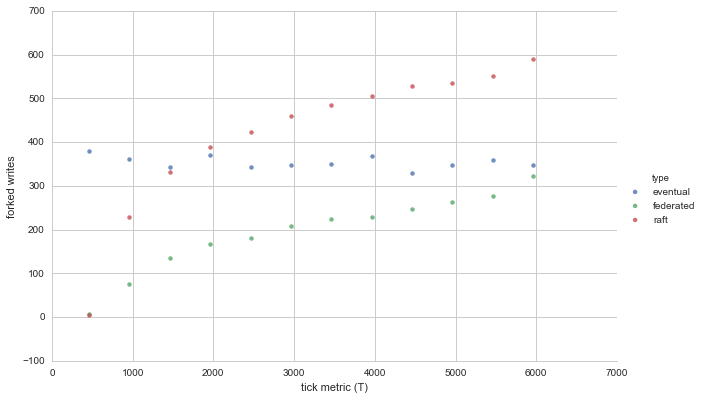

In [8]:
# Forked Writes
ax = sns.lmplot(
    x="tick metric (T)", y="forked writes", hue='type', 
    data=df, fit_reg=False, size=6, aspect=1.5
)

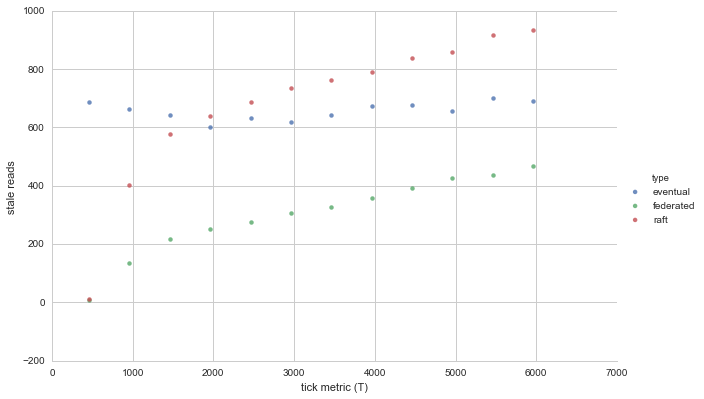

In [9]:
# Stale Reads
ax = sns.lmplot(
    x="tick metric (T)", y="stale reads", hue='type', 
    data=df, fit_reg=False, size=6, aspect=1.5
)

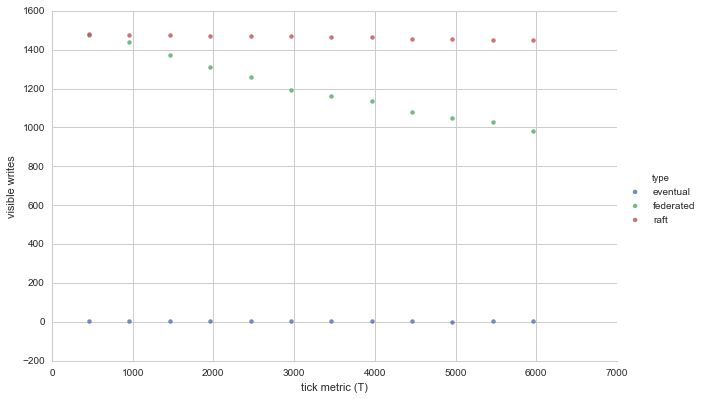

In [10]:
# Visible Writes
ax = sns.lmplot(
    x="tick metric (T)", y="visible writes", hue='type', 
    data=df, fit_reg=False, size=6, aspect=1.5
)

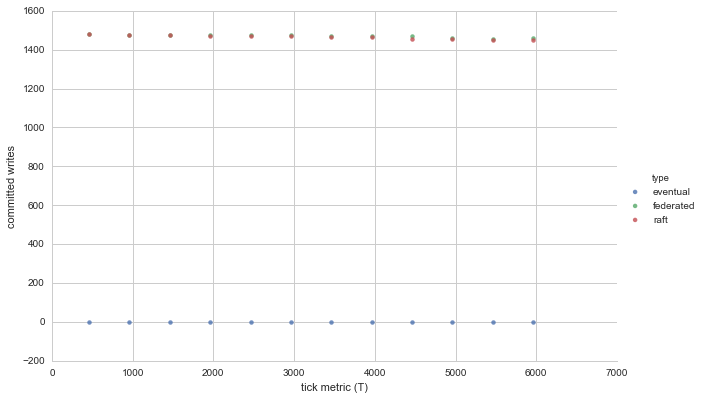

In [11]:
# Comitted Writes
ax = sns.lmplot(
    x="tick metric (T)", y="committed writes", hue='type', 
    data=df, fit_reg=False, size=6, aspect=1.5
)

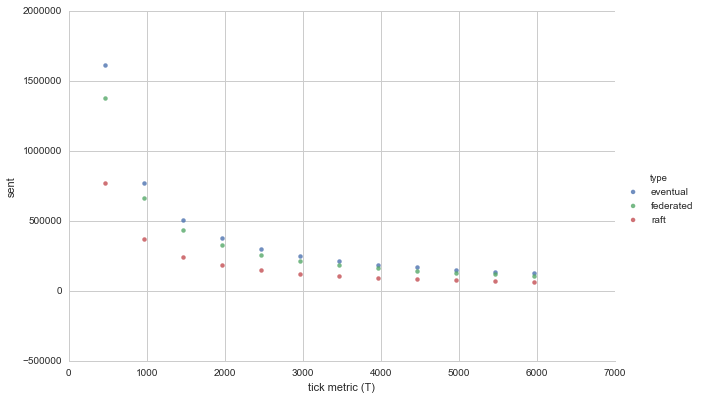

In [12]:
# Number of Messages 
ax = sns.lmplot(
    x="tick metric (T)", y="sent", hue='type', 
    data=df, fit_reg=False, size=6, aspect=1.5
)

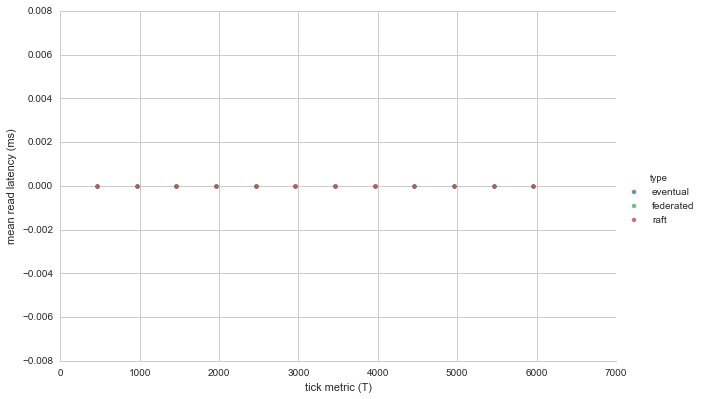

In [13]:
ax = sns.lmplot(
    x="tick metric (T)", y="mean read latency (ms)", hue='type', 
    data=df, fit_reg=False, size=6, aspect=1.5,
)

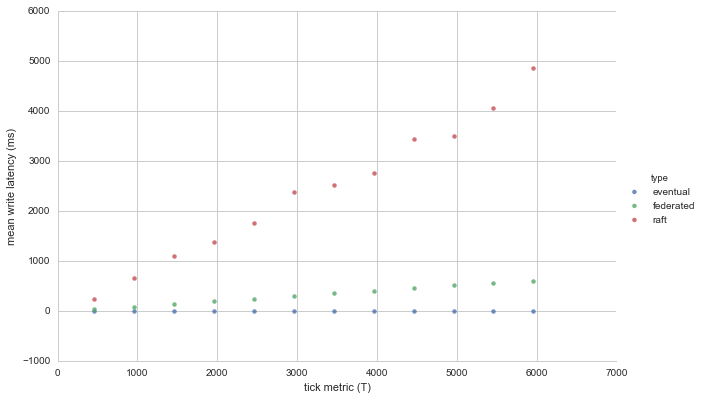

In [14]:
ax = sns.lmplot(
    x="tick metric (T)", y="mean write latency (ms)", hue='type', 
    data=df, fit_reg=False, size=6, aspect=1.5,
)

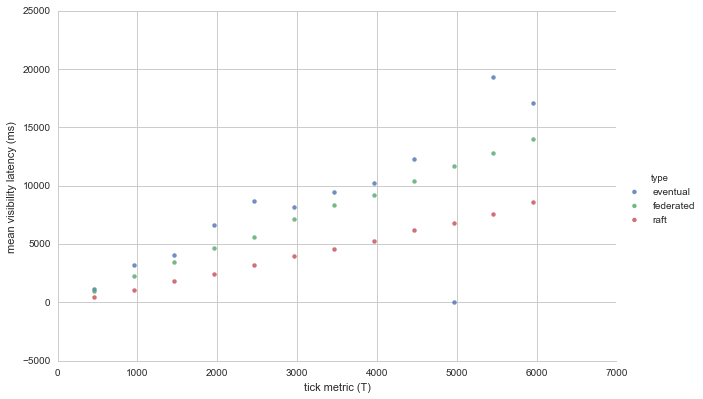

In [15]:
ax = sns.lmplot(
    x="tick metric (T)", y="mean visibility latency (ms)", hue='type', 
    data=df, fit_reg=False, size=6, aspect=1.5
)

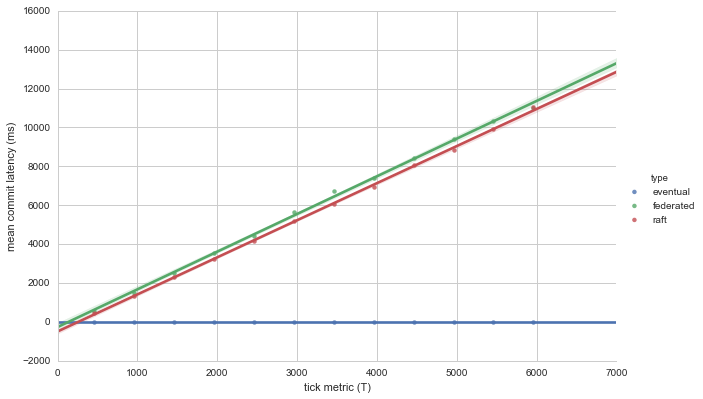

In [16]:
ax = sns.lmplot(
    x="tick metric (T)", y="mean commit latency (ms)", hue='type', 
    data=df, fit_reg=True, size=6, aspect=1.5
)

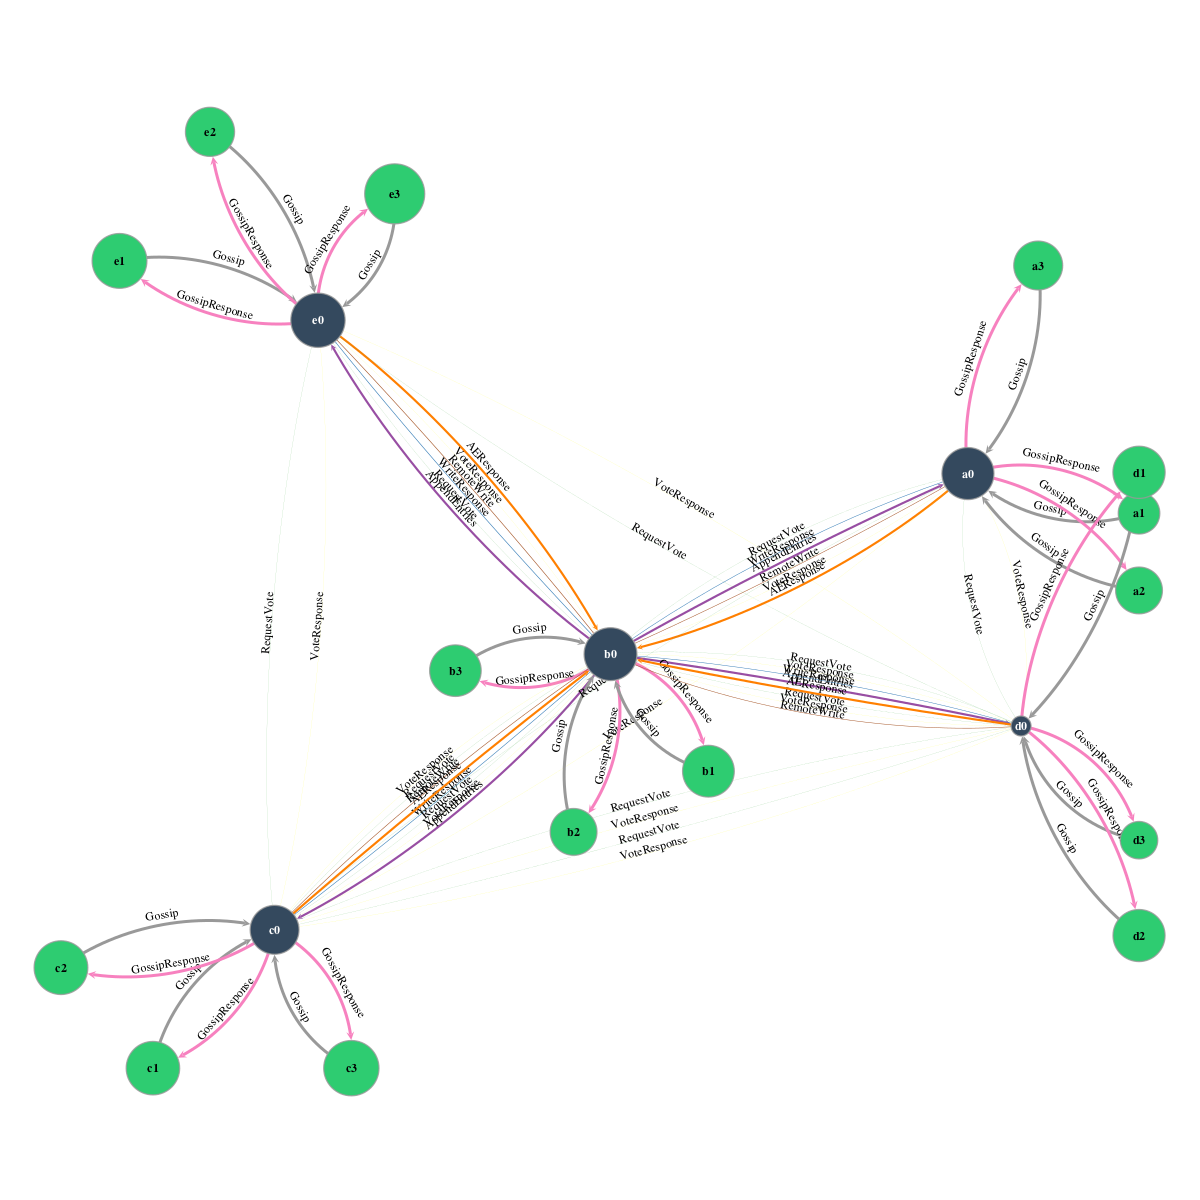

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1209d9890, at 0x1209e3c50>

In [17]:
def find_results(etype='federated', tick=1460):
    for result in results:
        if result.settings['type'] == etype and result.settings['tick_metric'] == tick:
            return result 
    return None 


# Extract the Graph Tool graph 
G = extract_graph(find_results('federated'), by_message_type=True)

# Draw the graph 
vlabel  = G.vp['id']
vsize   = G.vp['writes']
vsize   = gt.prop_to_size(vsize, log=True, ma=60, mi=20)

# Set the vertex color 
vcolor  = G.new_vertex_property('string') 
vcmap   = ColorMap('flatui', shuffle=False)
for vertex in G.vertices():
    vcolor[vertex] = vcmap(G.vp['consistency'][vertex])

# Set the edge color 
ecolor  = G.new_edge_property('string')
ecmap   = ColorMap('set1', shuffle=False)
for edge in G.edges():
    ecolor[edge] = ecmap(G.ep['label'][edge])

elabel  = G.ep['label']
esize   = G.ep['norm']
esize   = gt.prop_to_size(esize, mi=.1, ma=3)
eweight = G.ep['weight']

pos = gt.fruchterman_reingold_layout(G, weight=eweight)
gt.graph_draw(G, pos=pos, output_size=(1200,1200), output='/Users/benjamin/Desktop/eventual-network.png',
              vertex_text=vlabel, vertex_size=vsize, vertex_font_weight=1, 
              vertex_pen_width=1.3, vertex_fill_color=vcolor,
              edge_pen_width=esize, edge_color=ecolor, edge_text=elabel)